In [1]:
# Works best with jupyter-notebook

In [6]:
%matplotlib notebook 
#%matplotlib widget 
# https://ipython.readthedocs.io/en/stable/interactive/magics.html
import numpy as np
import roboticstoolbox as rtb
import spatialmath.base as sm
import matplotlib.pyplot as plt
import math
import time
from spatialmath import *
from spatialmath.base import *
from collections import namedtuple
from roboticstoolbox import *
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

##### Lecture 9.5

Inverting the Jacobian

In [7]:
# Load the Puma-560 robot model
puma = rtb.models.DH.Puma560()
print(puma)

┏━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃θⱼ  ┃   dⱼ    ┃   aⱼ   ┃   ⍺ⱼ   ┃   q⁻    ┃   q⁺   ┃
┣━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━━━╋━━━━━━━━━╋━━━━━━━━┫
┃ q1 ┃       0 ┃      0 ┃  90.0° ┃ -160.0° ┃ 160.0° ┃
┃ q2 ┃       0 ┃ 0.4318 ┃   0.0° ┃ -110.0° ┃ 110.0° ┃
┃ q3 ┃ 0.15005 ┃ 0.0203 ┃ -90.0° ┃ -135.0° ┃ 135.0° ┃
┃ q4 ┃  0.4318 ┃      0 ┃  90.0° ┃ -266.0° ┃ 266.0° ┃
┃ q5 ┃       0 ┃      0 ┃ -90.0° ┃ -100.0° ┃ 100.0° ┃
┃ q6 ┃       0 ┃      0 ┃   0.0° ┃ -266.0° ┃ 266.0° ┃
┗━━━━┻━━━━━━━━━┻━━━━━━━━┻━━━━━━━━┻━━━━━━━━━┻━━━━━━━━┛

┌─────┬─────┬──────┬───────┬─────┬──────┬─────┐
│name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5  │
├─────┼─────┼──────┼───────┼─────┼──────┼─────┤
│  qz │  0° │  0°  │  0°   │  0° │  0°  │  0° │
│  qr │  0° │  90° │ -90°  │  0° │  0°  │  0° │
│  qs │  0° │  0°  │ -90°  │  0° │  0°  │  0° │
│  qn │  0° │  45° │  180° │  0° │  45° │  0° │
└─────┴─────┴──────┴───────┴─────┴──────┴─────┘



In [8]:
print(puma.qn)

[       0   0.7854    3.142        0   0.7854        0]


<IPython.core.display.Javascript object>


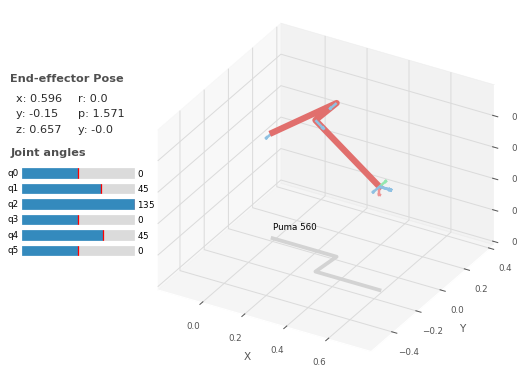

In [9]:
puma.teach(puma.qn)

In [10]:
#Compute the Jacobian of this pose
J=puma.jacob0(puma.qn)
J

array([[  0.1501,  0.01435,   0.3197,        0,        0,        0],
       [  0.5963,        0,        0,        0,        0,        0],
       [       0,   0.5963,    0.291,        0,        0,        0],
       [       0,        0,        0,   0.7071,        0,        1],
       [       0,       -1,       -1,        0,       -1,        0],
       [       1,        0,        0,  -0.7071,        0,        0]])

In [15]:
#test the determinant of the Jacobian matrix for the joint angle configuration qn
np.linalg.det(J)

-0.07861716534600001

In [16]:
#As it is not equal to 0, this means we can invert the Jacobian matrix
invJ=np.linalg.inv(J)
invJ

array([[       0,    1.677,        0,        0,        0,        0],
       [  -1.561,   0.3927,    1.715,        0,        0,        0],
       [   3.198,  -0.8048, -0.07699,        0,        0,        0],
       [       0,    2.372,        0,        0,        0,   -1.414],
       [  -1.638,   0.4121,   -1.638,        0,       -1,        0],
       [       0,   -1.677,        0,        1,        0,        1]])

In [17]:
#If we compute the Jacobian:
J=puma.jacob0(puma.qz)
J

array([[    0.15,  -0.4318,  -0.4318,        0,        0,        0],
       [  0.4521,        0,        0,        0,        0,        0],
       [       0,   0.4521,   0.0203,        0,        0,        0],
       [       0,        0,        0,        0,        0,        0],
       [       0,       -1,       -1,        0,       -1,        0],
       [       1,        0,        0,        1,        0,        1]])

In [18]:
np.linalg.det(J)
#The determinant in this case is 0.

0.0

In [19]:
#We are now going to look at resolved rate motion control. Compute the Jacobian matrix for the set of joint angles qn.
J=puma.jacob0(puma.qn)
J

array([[  0.1501,  0.01435,   0.3197,        0,        0,        0],
       [  0.5963,        0,        0,        0,        0,        0],
       [       0,   0.5963,    0.291,        0,        0,        0],
       [       0,        0,        0,   0.7071,        0,        1],
       [       0,       -1,       -1,        0,       -1,        0],
       [       1,        0,        0,  -0.7071,        0,        0]])

In [24]:
#Specify the spatial velocity for the end-effector as column vector nu with 1 unit/s in the z-direction
nu=[0,0,1,0,0,0]
invJ=np.linalg.inv(J)
JJ=np.dot(invJ,nu)
JJ

array([       0,    1.715, -0.07699,        0,   -1.638,        0])

This shows joints 1, 4 and 6 have no movement and that joint 2 is required to
move the fastest.